**Modification:**
- Apply attention for time

In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.layers import Input, Reshape, Flatten, merge
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers.normalization import BatchNormalization

Using Theano backend.


In [3]:
name = 'helpdesk'
sub_name = 'blstm_att' #activity-time
args = {
    'inputdir': '../input/{}/'.format(name),   
    'outputdir': './output_files/{0}_{1}/'.format(name, sub_name)
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir(args.outputdir):
    os.makedirs(args.outputdir)

In [5]:
with open(args.inputdir + 'parameters.pkl', "rb") as f:
    maxlen = pickle.load(f)
    num_features = pickle.load(f)
    chartoindice = pickle.load(f)
    targetchartoindice = pickle.load(f)
    divisor = pickle.load(f)
    divisor2 = pickle.load(f)

In [6]:
with open(args.inputdir + 'preprocessed_data.pkl', "rb") as f:
    X = pickle.load(f)
    y_a = pickle.load(f)
    y_t = pickle.load(f)
    X_test = pickle.load(f)
    y_a_test = pickle.load(f)
    y_t_test = pickle.load(f)

# Customized layer

In [7]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, constraints

In [8]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        #self.input_spec = [InputSpec(ndim=3)]
        super(AttLayer, self).__init__(** kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        #self.W = self.init((input_shape[-1],1))
        self.W = K.variable(self.init((input_shape[-1],)))
        #self.input_spec = [InputSpec(shape=input_shape)]
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x, self.W))

        ai = K.exp(eij)
        weights = ai/K.sum(ai, axis=1).dimshuffle(0,'x')

        weighted_input = x*weights.dimshuffle(0,1,'x')
        return weighted_input.sum(axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Model 1

In [9]:
# build the model: 
print('Build model attention for activity and output with blstm')
main_input = Input(shape=(maxlen, num_features), name='main_input')

# one shared layer
l1 = Bidirectional(LSTM(500, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True))(main_input)
b1 = BatchNormalization()(l1)

# the layer specialized in activity prediction
l2_1 =Bidirectional(LSTM(500, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True))(b1) 
b2_1 = BatchNormalization()(l2_1)
att_1 = AttLayer()(b2_1)

# the layer specialized in time prediction
l2_2 = Bidirectional(LSTM(500, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True))(l1) 
b2_2 = BatchNormalization()(l2_2)
att_2 = AttLayer()(b2_2)

act_output = Dense(len(targetchartoindice), activation="softmax", kernel_initializer="glorot_uniform", name="act_output")(att_1)
time_output = Dense(1, kernel_initializer="glorot_uniform", name="time_output")(att_2)


model = Model(inputs=[main_input], outputs=[act_output, time_output])

#compilations
opt = optimizers.Nadam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mean_absolute_error'}, 
              optimizer=opt, metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history = History()

#fit
model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history], batch_size=16, epochs=1000)

Build model attention for activity and output with blstm
Train on 7344 samples, validate on 1837 samples
Epoch 1/1000
538s - loss: 2.1192 - act_output_loss: 1.0167 - time_output_loss: 1.1025 - act_output_acc: 0.6849 - time_output_acc: 0.2640 - val_loss: 2.1912 - val_act_output_loss: 1.1589 - val_time_output_loss: 1.0323 - val_act_output_acc: 0.5514 - val_time_output_acc: 0.2869
Epoch 2/1000
558s - loss: 1.8011 - act_output_loss: 0.7537 - time_output_loss: 1.0474 - act_output_acc: 0.7606 - time_output_acc: 0.2802 - val_loss: 1.6502 - val_act_output_loss: 0.6167 - val_time_output_loss: 1.0336 - val_act_output_acc: 0.8100 - val_time_output_acc: 0.2869
Epoch 3/1000
558s - loss: 1.7142 - act_output_loss: 0.6825 - time_output_loss: 1.0317 - act_output_acc: 0.7879 - time_output_acc: 0.2804 - val_loss: 1.6030 - val_act_output_loss: 0.5947 - val_time_output_loss: 1.0083 - val_act_output_acc: 0.8182 - val_time_output_acc: 0.2869
Epoch 4/1000
553s - loss: 1.6700 - act_output_loss: 0.6468 - time_o

KeyboardInterrupt: 

# Model 2

In [ ]:
# build the model: 
print('Build model attention for activity and output...')
main_input = Input(shape=(maxlen, num_features), name='main_input')

# one shared layer
l1 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True)(main_input)
b1 = BatchNormalization()(l1)

# the layer specialized in activity prediction
l2_1 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True)(b1) 
b2_1 = BatchNormalization()(l2_1)
att_1 = AttLayer()(b2_1)

# the layer specialized in time prediction
l2_2 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False)(l1) 
b2_2 = BatchNormalization()(l2_2)


act_output = Dense(len(targetchartoindice), activation="softmax", kernel_initializer="glorot_uniform", name="act_output")(att_1)
time_output = Dense(1, kernel_initializer="glorot_uniform", name="time_output")(b2_2)


model = Model(inputs=[main_input], outputs=[act_output, time_output])

#compilations
opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mean_absolute_error'}, 
              optimizer=opt, metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=83)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history = History()

#fit
model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history], batch_size=16, epochs=500)

# Plot

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 15, 14)        0                                            
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 15, 1000)      2060000     main_input[0][0]                 
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 15, 1000)      4000        bidirectional_1[0][0]            
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 15, 1000)      6004000     batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [11]:
history.history.keys()

dict_keys(['act_output_loss', 'val_time_output_loss', 'val_act_output_loss', 'loss', 'val_time_output_acc', 'act_output_acc', 'time_output_loss', 'val_loss', 'time_output_acc', 'val_act_output_acc', 'lr'])

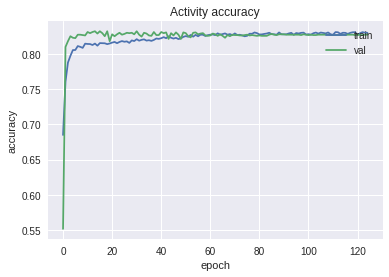

In [12]:
# summarize history for activity accuracy
plt.plot(history.history['act_output_acc'])
plt.plot(history.history['val_act_output_acc'])
plt.title('Activity accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

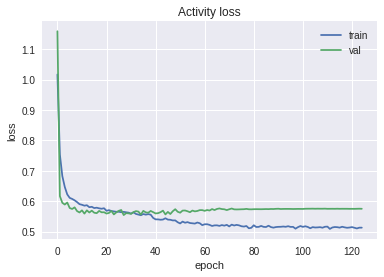

In [13]:
# summarize history for activity loss
plt.plot(history.history['act_output_loss'])
plt.plot(history.history['val_act_output_loss'])
plt.title('Activity loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

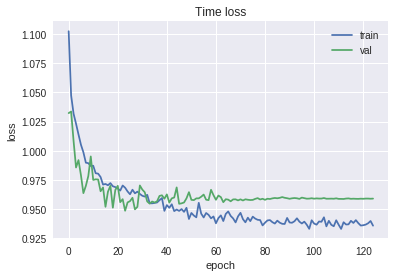

In [14]:
# summarize history for time loss
plt.plot(history.history['time_output_loss'])
plt.plot(history.history['val_time_output_loss'])
plt.title('Time loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# summarize history for model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()